# Inference with pretrained networks

You can find additional visualization utilities in [this link](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py)

## Imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import convert_image_dtype
import torchvision.transforms.functional as F
import numpy as np

## 1. Create a function to load, visualize and preprocess the image

In [3]:
def load_image(image_path, preprocess):
    
    # Load and visualize the image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    
    # Pass the image through our preprocessing pipeline:
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # Add an extra dimension at the beginning of the tensor
    
    return input_batch

# 2. Load  pretrained models available in torchvision

In [4]:
# Load the pretrained classification model
classification_model = models.resnet18(pretrained = True)
classification_model.eval()

# Load the pretrained segmentation model
segmentation_model = models.segmentation.fcn_resnet50(pretrained = True)
segmentation_model.eval()

# Load the pretrained detection model
detection_model = models.detection.maskrcnn_resnet50_fpn(pretrained = True)
detection_model.eval()

print()

# Classification

In this case, we define a function that will scale the input image to 256 ×
256, crop the image to 224 × 224 around the center, transform it to a tensor, and normalize its RGB (red, green, blue) components so that they have
defined means and standard deviations.

In [5]:
# Define the transforms
preprocess_classification = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])

Now we can choose any image we want to work with. Modify the variable to match the path of your image. 
**You can find the example image used in this notebook in the 'data' folder**.

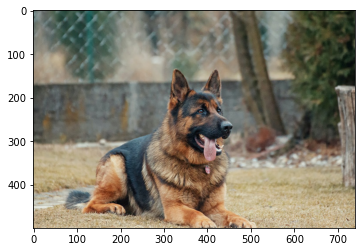

In [6]:
# Load and visualize the image
image_path = "../../data/german_shepherd_image.jpg" # SELECT THE PATH OF YOUR IMAGE
input_image = load_image(image_path, preprocess_classification)

 Many of the pretrained classification models available in torchvision.models used the **ImageNet dataset** during their pretraining phase. These models return a vector with 1000 scores, one per ImageNet class.

We now need to find out the label of the class that receives the highest score. This
will tell us what the model sees in the image. Since the model produces scores, we can also find out what the second best, third best, and so on are. In this example we will identify the top five most probable classes.

We'll load a text file that lists the labels in the same order as they were presented to the network during training. Then, we'll select the labels with the highest scores produced by the network.

**The text file with the labels is available in the "data" folder**

In [7]:
# Let’s load the file containing the 1000 labels for the ImageNet dataset classes:
with open('../../data/ImageNet_labels.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [8]:
# Classification inference: Obtain the predictions for each cathegory
with torch.no_grad():
    output = classification_model(input_image)

# Transforms the predictions intro probabilities with the softmax function
probabilities = torch.nn.functional.softmax(output, dim = 1)[0] * 100

# Print the top five most probable classes with their probabilities 
_, indices = torch.sort(output, descending = True)
[(labels[idx], probabilities[idx].item()) for idx in indices[0][:5]]

[('235, German_shepherd', 99.70854949951172),
 ('225, malinois', 0.19755354523658752),
 ('174, Norwegian_elkhound', 0.07259954512119293),
 ('255, Leonberg', 0.012983403168618679),
 ('676, muzzle', 0.0016750470967963338)]

As you can see above, the network is 99.7% sure that the image represents a german shepherd

# Segmentation 

In [9]:
# Define the transforms: In this case, we won't crop the image
preprocess_segmentation = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )])

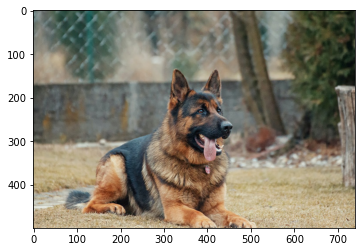

In [10]:
# Load and visualize the image
image_path = "../../data/german_shepherd_image.jpg" # SELECT THE PATH OF YOUR IMAGE
input_image = load_image(image_path, preprocess_segmentation)

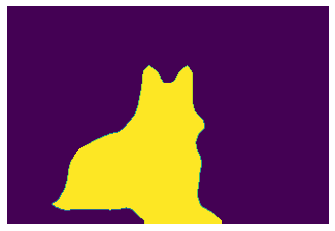

In [11]:
# Segmentation inference
with torch.no_grad():
    output = segmentation_model(input_image)['out']
    output_predictions = output.argmax(1).squeeze().detach().cpu().numpy()

# Display the segmentation mask
plt.imshow(output_predictions)
plt.axis('off')
plt.show()

# Detection 

In [12]:
# Define the transforms
preprocess_detection = transforms.Compose([
    transforms.Resize((520)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.uint8) ])

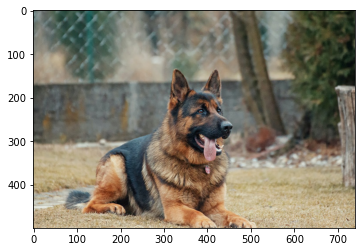

In [13]:
# Load and visualize the image
image_path = "../../data/german_shepherd_image.jpg" # SELECT THE PATH OF YOUR IMAGE
input_image = load_image(image_path, preprocess_detection)

In [15]:
# Detection inference
batch = convert_image_dtype(input_image, dtype = torch.float)
with torch.no_grad():
    outputs = detection_model(batch)

In [16]:
# Define a function to show the image with the bounding boxes
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

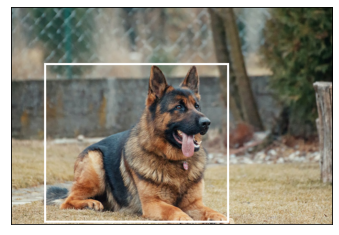

In [17]:
# We will load the original image and then proceed to draw the bounding boxes over it
original_image = Image.open(image_path).convert("RGB")
original_image = preprocess_detection(original_image)

score_threshold = .8
imagen_with_boxes = [
    draw_bounding_boxes(original_image, boxes=output['boxes'][output['scores'] > score_threshold], width=5)
    for imagen_int, output in zip(input_image, outputs)
]
show(imagen_with_boxes)

### Exercise 1: Repeat the inference using at least one more network for each task and check the results

### Exercise 2: Modify the classification example to perform threshold-based classification instead of top-k classification. Instead of printing the top-5 most probable classes, you should modify the code to print the classes whose probabilities exceed a certain threshold value (>80%)

### Exercise 3: Modify the segmentation example to visualize the mask (dog) in white and the background in black. Display the segmentation mask next to the original image as shown:

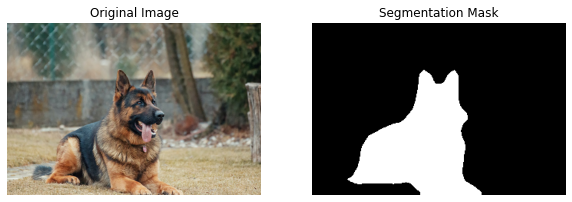

In [243]:
# WRITE YOUR CODE HERE

### Exercise 4: Modify the detection example to visualize the bounding box in red with a width of 10 as shown:

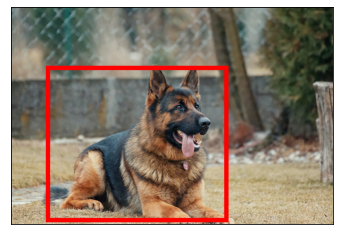

In [285]:
# WRITE YOUR CODE HERE